# Lineare Regression

Open in Colab: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/febse/opt2025-de/blob/main/Prediction.ipynb)

In dem Beispiel mit der Produktion- und Distributionsplanung (@sec-production-distribution) war die Nachfrage in den Standorten vorgegeben. Sehr häufig ist es aber so, dass die Nachfrage nicht bekannt ist und geschätzt werden muss.

Als ein einfaches Beispiel für eine Schätzung der Nachfrage nach Backsteinen nehmen wir an, dass die Nachfrage in einem Monat $t$ mit der folgenden Gleichung beschrieben werden kann:

$$
\begin{align*}
\text{Nachfrage}_{t} & = \beta_0 + \beta_1 t + e_t \\
\end{align*}
$$

wobei $\beta_0$ und $\beta_1$ unbekannte Parameter sind, die geschätzt werden müssen, und $e_t$ ein Zufallsfehler ist. Der Index $t$ beschreibt den Monat, in dem die Nachfrage auftritt und läuft von $t=1$ bis $t=T$.

Konkret, nehmen wir an, dass die Nachfrage in jedem Monat durch die folgende Gleichung beschrieben ist:

$$
\begin{align*}
\text{Nachfrage}_{t} = 40 + 0.2 t + e_t
\end{align*}
$$

Um die Notation zu vereinfachen, schreiben wir $y_{t}$ statt $\text{Nachfrage}_{t}$. Für die Fehlerterme
$e_t$ nehmen wir an, dass sie normalverteilt sind mit einem Mittelwert von 0 und einer Varianz von $\sigma^2 = 2$. Ferner nehmen wir an, dass die Fehlerterme $e_t$ unabhängig sind.

Das Modell ist dann:

$$
\begin{align*}
y_{t} & = 40 + 1.5 t + e_t \\
e_t & \sim N(0, 2)
\end{align*}
$$

In [1]:
%pip install gurobipy

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

np.random.seed(0)

# Generate some example data

periods = 10

dt = pd.DataFrame({
        "time": np.arange(periods) + 1,
        "noise": np.random.randn(periods) * 2
    })

dt["y"] = 40 + 1.5 * dt["time"] + dt["noise"]
dt

/home/amarov/stats/opt2026-de/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


,time,noise,y
0,1,3.528105,45.028105
1,2,0.800314,43.800314
2,3,1.957476,46.457476
3,4,4.481786,50.481786
4,5,3.735116,51.235116
5,6,-1.954556,47.045444
6,7,1.900177,52.400177
7,8,-0.302714,51.697286
8,9,-0.206438,53.293562
9,10,0.821197,55.821197


In dem Datensatz `dt` haben wir drei Spalten mit jeweils 10 Zeilen erstellt. Die Spalte `time` gibt den Monat an und hat Werte von 1 bis 10. Die Spalte `y` ist die beobachtete Nachfrage.

Text(0, 0.5, 'Backsteine')

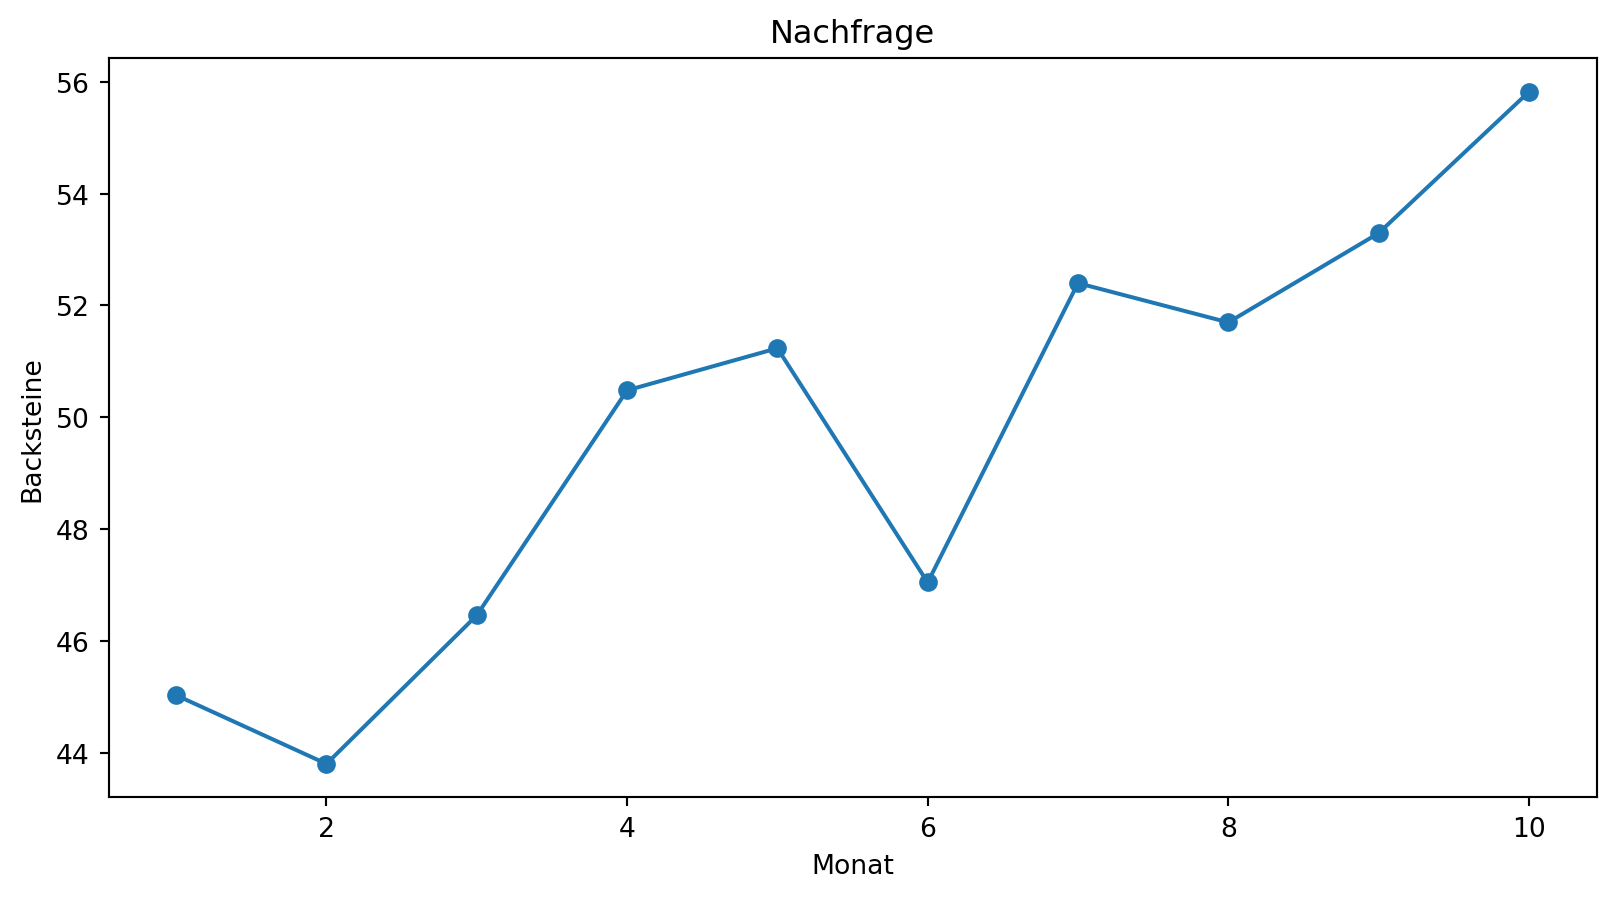

In [2]:
# Plot the data

plt.figure(figsize=(10, 5))
plt.plot(dt["time"], dt["y"], 'o-', label='Data')
plt.title('Nachfrage')
plt.xlabel('Monat')
plt.ylabel('Backsteine')


Üblicherweise kennen wir das Modell (d.h. die Struktur und die Parameter) nicht, sondern wir haben nur die Daten, die wir zur Schätzung der Parameter verwenden können. In unserem Beispiel haben wir also eine Zeitreihe von Beobachtungen der Nachfrage $y_{t}$ für $t=1,2,\ldots,T=10$.

Zum Beispiel, es seien $\beta_0 = 44, \beta_1 = 0.2$. Um die geschätzte Nachfrage in einem Monat $t$ zu berechnen, setzen wir die Werte in die Gleichung ein:

$$
\begin{align*}
\hat{y}_{t} & = 44 + 0.2 t \\
\end{align*}
$$

Im Monat $t = 4$ wäre die geschätzte Nachfrage:

$$
\begin{align*}
\hat{y}_{t} & = 44 + 0.2 \cdot 4 \\
& = 39 + 1.2 \\
& = 40.2 \\
\end{align*}
$$

Die tatsächliche Nachfrage in diesem Monat ist jedoch $50.48$ (das ist der vierte Wert der Spalte `y` im Datensatz `dt`). Der Fehler in der Schätzung beträgt:

$$
\begin{align*}
r_4 & = y_{4} - \hat{y}_{4} \\
& = 50.48 - 44.8 \\
& = 5.68 \\
\end{align*}
$$

Diese Fehler werden wir **Residuen** oder Abweichungen zwischen Schätzung und tatsächlichem Wert nennen.

In [3]:
# Im folgenden Code berechnen wir die Prognosen und die Residuen für alle Monate im Datensatz

dt["y_predicted_naive"] = 45 + 0.6 * dt["time"]  # Example trend line
dt["residuals_naive"] = dt["y"] - dt["y_predicted_naive"]
dt

,time,noise,y,y_predicted_naive,residuals_naive
0,1,3.528105,45.028105,45.6,-0.571895
1,2,0.800314,43.800314,46.2,-2.399686
2,3,1.957476,46.457476,46.8,-0.342524
3,4,4.481786,50.481786,47.4,3.081786
4,5,3.735116,51.235116,48.0,3.235116
5,6,-1.954556,47.045444,48.6,-1.554556
6,7,1.900177,52.400177,49.2,3.200177
7,8,-0.302714,51.697286,49.8,1.897286
8,9,-0.206438,53.293562,50.4,2.893562
9,10,0.821197,55.821197,51.0,4.821197


Text(0, 0.5, '$r_t$')

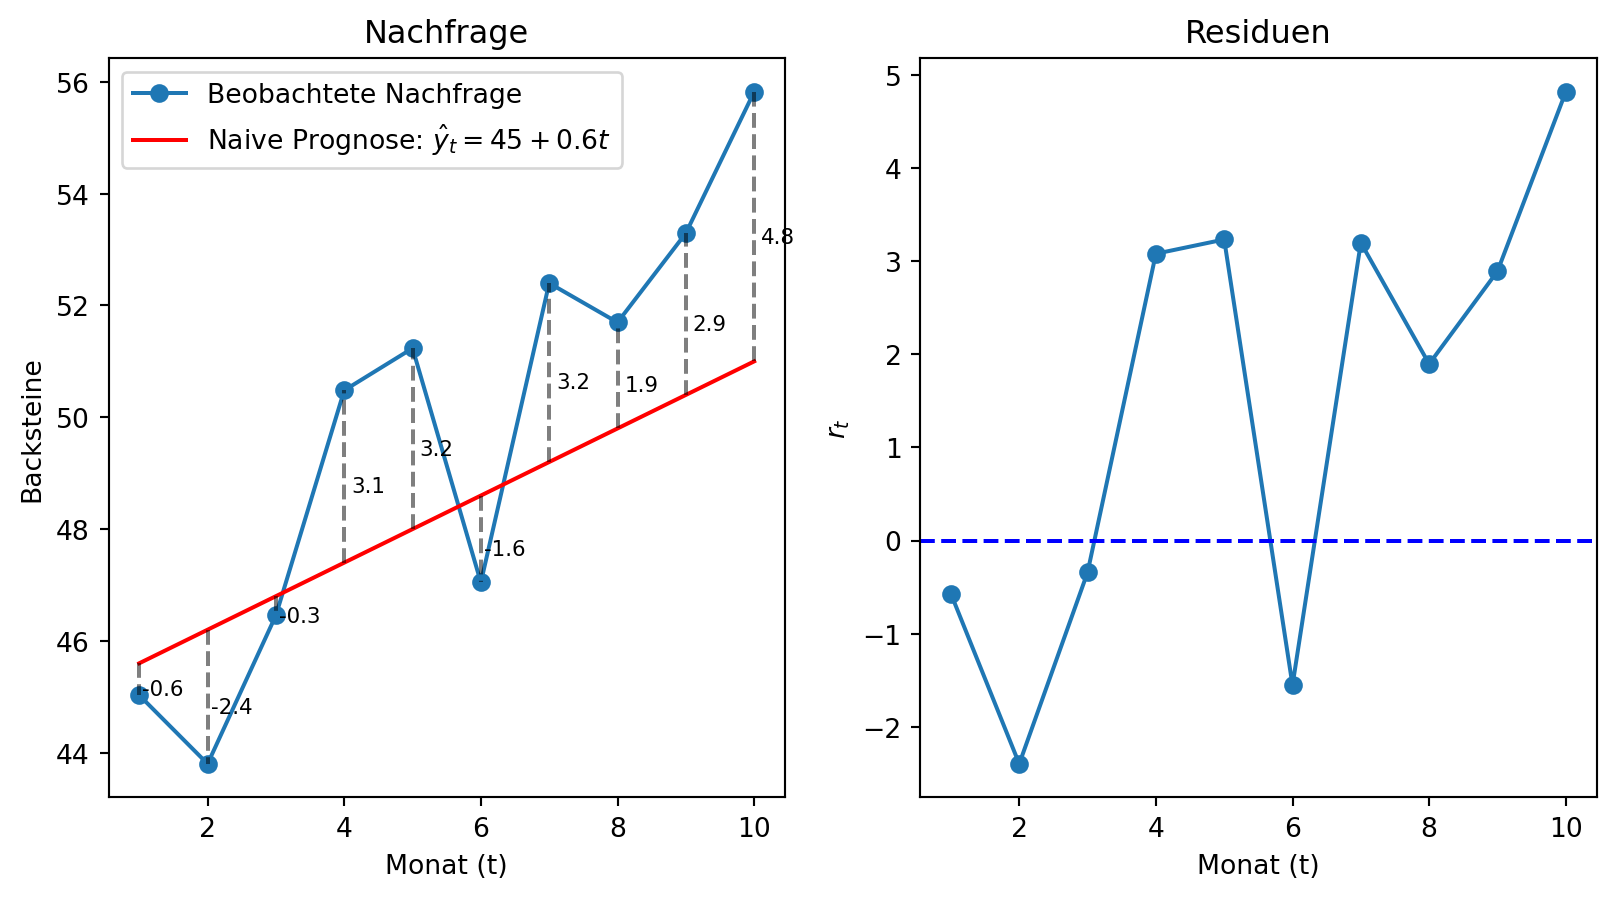

In [4]:
# Danach zeichnen wir die Prognose (die rote Gerade) und die Residuen

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
axes[0].plot(dt["time"], dt["y_predicted_naive"], 'r-', label=r'Naive Prognose: $\hat{y}_t = 45 + 0.6 t$')

# Plot the residuals as vertical lines
for i in range(len(dt)):
    axes[0].plot([dt["time"][i], dt["time"][i]], [dt["y_predicted_naive"][i], dt["y"][i]], 'k--', alpha=0.5)
    # Plot the residuals as labels
    axes[0].text(dt["time"][i] + 0.35, (dt["y_predicted_naive"][i] + dt["y"][i]) / 2, f"{dt['residuals_naive'][i]:.1f}", fontsize=8, ha='center', va='top')

axes[0].set_title('Nachfrage')
axes[0].set_xlabel('Monat (t)')
axes[0].set_ylabel('Backsteine')
axes[0].legend()

# Plot the residuals

axes[1].plot(dt["time"], dt["residuals_naive"], 'o-', label='Residuals')
axes[1].axhline(0, color='b', linestyle='--')
axes[1].set_title('Residuen')
axes[1].set_xlabel('Monat (t)')
axes[1].set_ylabel(r"$r_t$")


Nun haben wir eine Gerade, die wir für die Schätzung der Nachfrage verwenden können.

Z.B., um die Nachfrage im Monat $t = 11$ zu schätzen, setzen wir den Wert in die Gleichung ein:

$$
\begin{align*}
\hat{y}_{11} & = 44 + 0.2 \cdot 11 \\
& = 44 + 2.2 \\
& = 46.2 \\
\end{align*}
$$

Diesen Wert können wir jetzt als Parameter für die Planung der Produktion (z.B.) benutzen.


Ist das aber die **beste** Prognose? Wenn ja, in welchem Sinne ist sie die beste? Die Größe eines Residuums sagt uns wie nah die Gerade am tatsächlichen Wert liegt. Z.B. verläuft die Gerade näher am ersten Punk ($t = 1, r_1 = -0.6$) als am letzten Punkt ($t = 10, r_{10} = 4.8$). Wie nah ist aber diese Gerade an allen Punkten? Um diese Frage zu beantworten, müssen wir die Residuen irgendwie zusammenfassen (aggregieren).

$$
\begin{align*}
RSS(\beta_0, \beta_1) = \sum_{t=1}^{T} (y_t - \hat{y}_t)^2 = \sum_{t=1}^{T} (y_t - \beta_0 - \beta_1 t)^2
\end{align*}
$$

Wir verwenden die Englischsprachige Abkürzung **RSS** (Residual Sum of Squares) für die Residuenquadratsumme. Das ist eine Funktion, die von den Koeffizienten $\beta_0$ und $\beta_1$ abhängt. Sie hängt natürlich auch von den Daten ab, aber diese betrachten wir als fixe Werte. Die RSS nimmt die zwei Koeffizienten $\beta_0$ und $\beta_1$ und produziert eine positive Zahl (oder Null). Kleinere Werte der RSS bedeuten, dass die Gerade näher an den Punkten liegt (bessere Prognosen). Größere Werte bedeuten, dass die Gerade weiter von den Punkten entfernt ist (schlechtere Prognosen).

Lassen Sie uns zwei (beliebige) Gleichungen vergleichen:

$$
\begin{align*}
\hat{y}_{t} & = 42 + 1.7 t \quad (1) \\
\hat{y}_{2} & = 50 + 0.3 t \quad (2) \\
\end{align*}
$$


In [5]:
# Wir berechnen die Prognosen für die zwei Modelle

predicted_1 = 42 + 1.7 * dt["time"]
predicted_2 = 50 + 0.3 * dt["time"]

# Nach den Prognosen berechnen wir die Residuen für beide Modelle
residuals_1 = dt["y"] - predicted_1
residuals_2 = dt["y"] - predicted_2

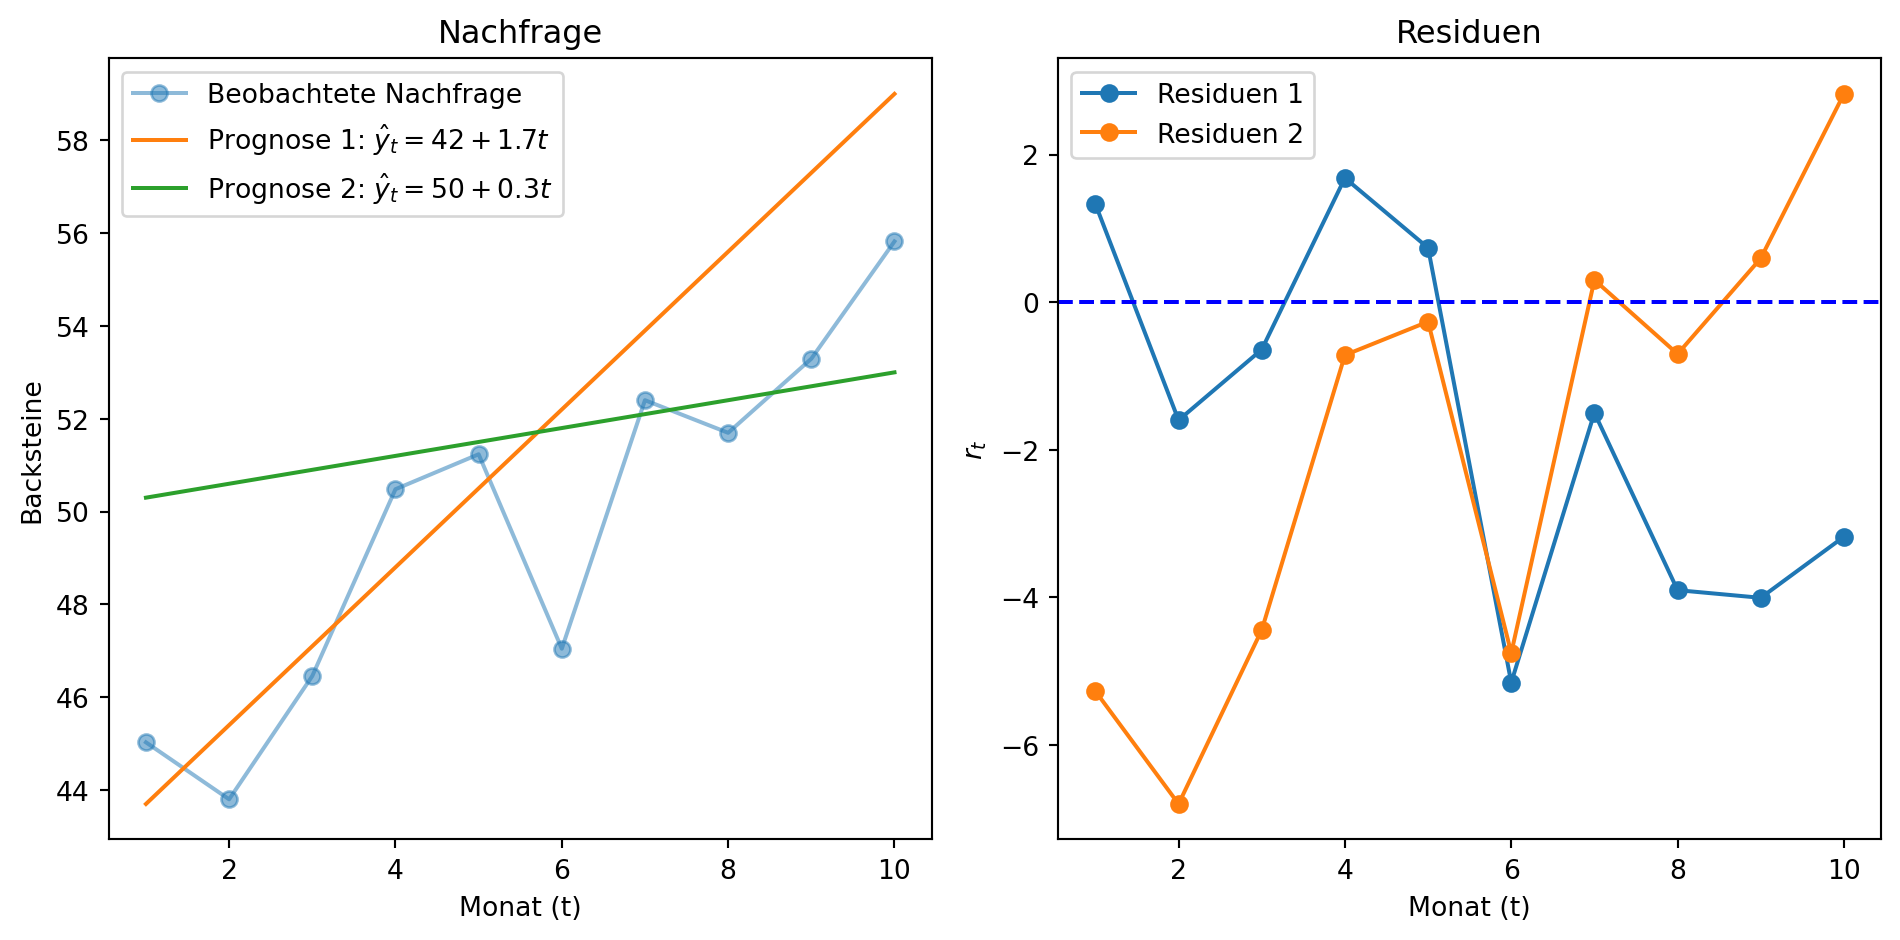

In [6]:
# Wir möchten die zwei Geraden und die Residuen zeichnen

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage', alpha =0.5)
axes[0].plot(dt["time"], predicted_1, '-', label=r'Prognose 1: $\hat{y}_t = 42 + 1.7 t$')
axes[0].plot(dt["time"], predicted_2, '-', label=r'Prognose 2: $\hat{y}_t = 50 + 0.3 t$')

axes[0].set_title('Nachfrage')
axes[0].set_ylabel('Backsteine')
axes[0].set_xlabel('Monat (t)')
axes[0].legend()


# Plot the residuals in the second subplot

axes[1].plot(dt["time"], residuals_1, 'o-', label='Residuen 1')
axes[1].plot(dt["time"], residuals_2, 'o-', label='Residuen 2')
axes[1].axhline(0, color='b', linestyle='--')
axes[1].set_title('Residuen')
axes[1].set_xlabel('Monat (t)')
axes[1].set_ylabel(r"$r_t$")
axes[1].legend()
plt.tight_layout()
plt.show()


Nun könnten wir die RSS für beide Gleichungen berechnen und vergleichen.

$$
\begin{align*}
RSS(42, 1.7) & = 78.31 \\
RSS(50, 0.3) & = 125.85 \\
\end{align*}
$$

Die erste Gerade hat eine kleinere RSS als die zweite. Das bedeutet, dass die erste Gerade näher an den Punkten liegt und damit besser ist.

In [7]:
(residuals_1 ** 2).sum(), (residuals_2 ** 2).sum()

(np.float64(78.31092014872564), np.float64(125.85180115549095))

## Die Methode der kleinsten Quadrate (KQ)

Bisher haben wir gesehen, wie wir die Residuenquadratsumme (RSS) benutzen können, um verschiedene Prognosegleichungen zu vergleichen. Die interessante Frage ist aber, ob wir die **beste** Prognosegleichung finden können. Das heißt, die Gleichung mit der kleinsten RSS. Das macht die Methode der kleinsten Quadrate (auf Englisch Ordinary Least Squares, OLS). OLS sucht nach denjenigen Werten von $\beta_0$ und $\beta_1$, die die RSS minimieren.

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t=1}^{T} (y_t - \hat{y}_t)^2 = \min_{\beta_0, \beta_1} \sum_{t=1}^{T} (y_t - \beta_0 - \beta_1 t)^2
\end{align*}
$$

## RSS mit nur einem Koeffizienten

Am einfachsten ist es, die Summe der quadrierten Abweichungen nur in Bezug auf $\beta_0$ zu minimieren.

Die Schätzung der Nachfrage in diesem Fall ist:

$$
\hat{y}_t = \hat{\beta}_0
$$

und die Summe der quadrierten Abweichungen ist:

$$
\begin{align*}
\sum_{t=1}^{T} (y_t - \beta_0)^2
\end{align*}
$$

Graphisch ist das eine Parabel, die nach oben geöffnet ist. Der Wert von $\beta_0$ für den die Summe der quadrierten Abweichungen minimal ist, in der Abbildung unten ist das ein Wert irgendwo zwischen 48 and 49.

Text(0, 0.5, 'Summe der quadrierten Residuen')

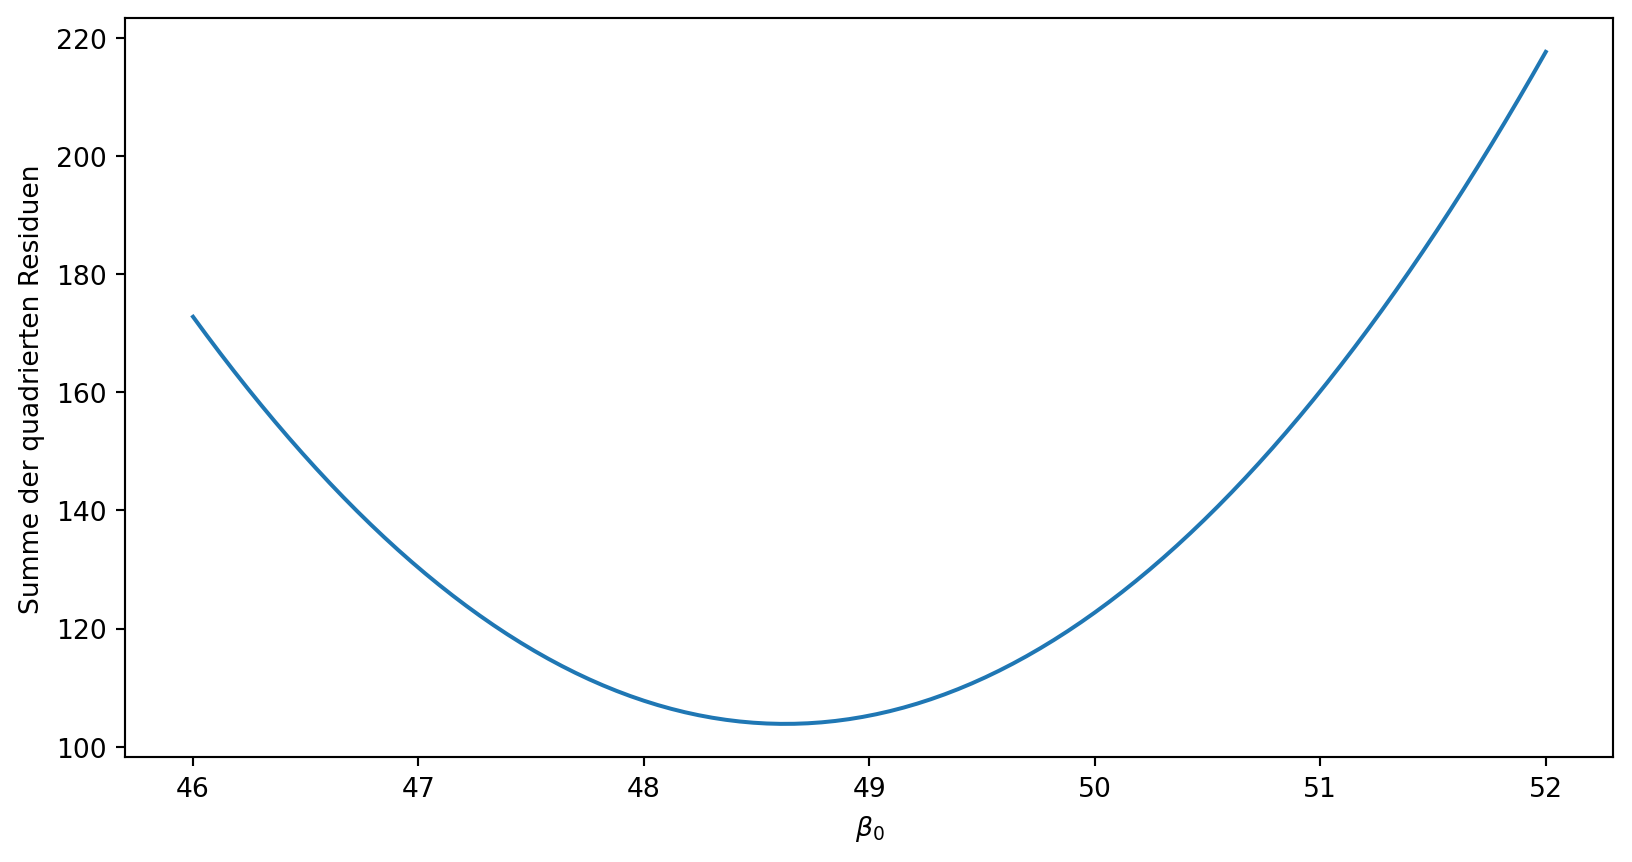

In [8]:
#| code-fold: true

# Visualize the residual sum of squares for a range of beta_0 values

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted
    
# Calculate the residual sum of squares
rss = np.sum(residuals**2, axis=1)

# Plot the residual sum of squares

plt.figure(figsize=(10, 5))
plt.plot(beta_0_values, rss)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der quadrierten Residuen')

## RSS mit zwei Koeffizienten

In dem Fall mit zwei Koeffizienten $\beta_0$ und $\beta_1$ ist die Schätzung:

$$
\hat{y}_t = \beta_0 + \beta_1 t
$$

und die Summe der quadrierten Abweichungen ist:

$$
\begin{align*}
\sum_{t=1}^{T} (y_t - (\beta_0 + \beta_1 t))^2
\end{align*}
$$

Da die RSS von zwei Variablen abhängt, brauchen wir eine dritte Dimension, um die Funktion zu zeichnen. Das ist in der Abbildung unten dargestellt. 

Text(0.5, 0, 'Quadratsumme der Residuen')

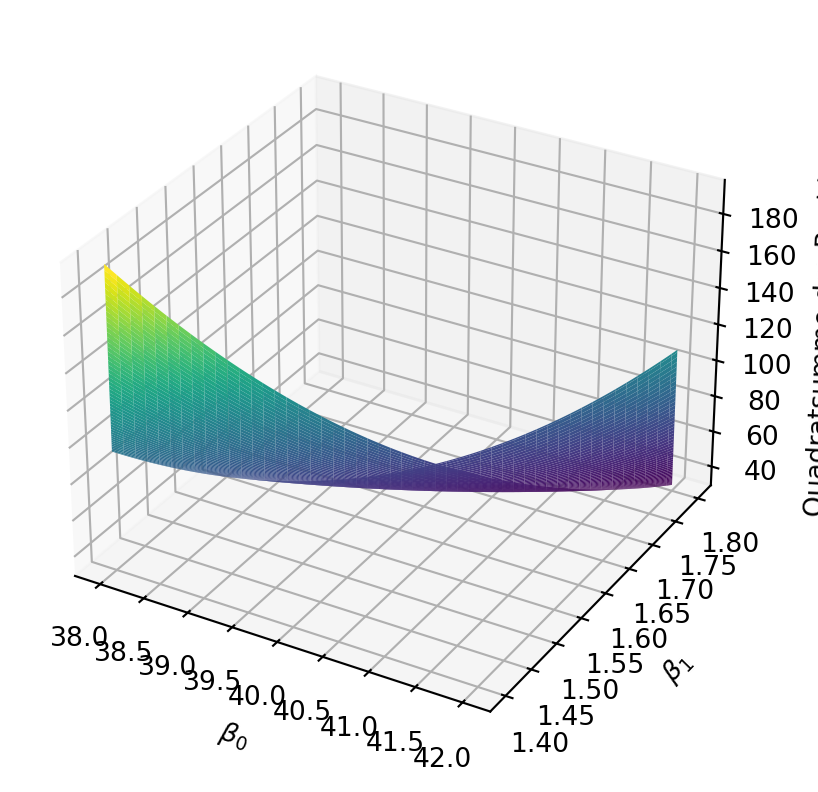

In [9]:
#| code-fold: true

# Visualize the residual sum of squares for a range of parameters

beta_0_values = np.linspace(38, 42, 100)
beta_1_values = np.linspace(1.4, 1.8, 100)

RSS = np.zeros((len(beta_0_values), len(beta_1_values)))

for i in range(len(beta_0_values)):
    for j in range(len(beta_1_values)):
        y_predicted = beta_0_values[i] + beta_1_values[j] * dt["time"]
        RSS[i, j] = np.sum((dt["y"] - y_predicted) ** 2)

# Plot the RSS surface

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(beta_0_values, beta_1_values, RSS.T, cmap='viridis', edgecolor='none')

ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('Quadratsumme der Residuen')

## OLS mit Gurobi

Wir werden nun `Gurobi` verwenden, um die Werte von $\beta_0$ und $\beta_1$ zu finden, die die RSS minimieren. Unsere Zielfunktion ist die RSS:

$$
\begin{align*}
\min \sum_{t=1}^{T} (y_t - (\beta_0 + \beta_1 t))^2 = \min \sum_{t=1}^{T} r_t^2
\end{align*}
$$

Die Residuen $r_t$ sind:

$$
\begin{align*}
r_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,2,\ldots, T=10\\
\end{align*}
$$

:::{.callout-note}
## Unbeschränkte Variablen

Bei der Umsetzung in `Gurobi` müssen wir darauf achten, dass sowohl die Residuen und die Koeffizienten auch negativ sein können. Die Voreinstellung in `Gurobi` ist, dass die Variablen nichtnegativ sind. Deswegen setzen wir die untere Schranken auf $-\infty$ (`lb=-GRB.INFINITY`).

:::
:::{.callout-note}
## Gurobi Matrixvariablen

Das Program werden wir mit `Gurobi` Matrixvariablen umsetzen. Diese erleichtern 
die Implementierung, denn wir können Schleifen durch Matrixoperationen ersetzen. Beachten Sie, dass
wir in dem Code unten die Variablen durch `m.addMVar` statt `m.addVars` erstellen.

:::

:::{.callout-note}
## Die Pandas-Series und ihre Werte (technisches Detail)

In der Umsetzung mit `Gurobi` unten verwenden wir die Pandas-Series `dt['y']` und `dt['time']` (das sind die Spalten `y` und `time` des DataFrames `dt`).

Die Pandas-Series sind eine Art von Datenstruktur, die ein Array (eine pezielle Liste von Werten) mit einem Index verknüpft. Manche Operationen brauchen nur die Werte in dem Array und auf diese können wir über die Eigenschaft `.values` zugreifen. 

Deswegen gibt es in dem Code `dt["y"].values` und `dt["time"].values`

```{python}
m.addConstr(dt["y"].values - (beta_0 + beta_1 * dt["time"].values) == residuals, name="Residuals")
```

:::



In [10]:
dt["y"]

0    45.028105
1    43.800314
2    46.457476
3    50.481786
4    51.235116
5    47.045444
6    52.400177
7    51.697286
8    53.293562
9    55.821197
Name: y, dtype: float64

In [11]:
dt["y"].values

array([45.02810469, 43.80031442, 46.45747597, 50.4817864 , 51.23511598,
       47.04544424, 52.40017684, 51.69728558, 53.2935623 , 55.821197  ])


:::{.callout-note}
## Vektoroperationen

Die Umsetzung mit `Gurobi` ist sehr einfach, weil wir die Residuen als Vektoroperationen umsetzen können. Das bedeutet, dass wir die Residuen nicht einzeln berechnen müssen, diese Arbeit macht `Gurobi` für uns.

Wenn wir `beta_1 * dt["time"].values` schreiben, versteht gurobi, dass es jeden Wert von `dt["time"].values` mit dem Wert von `beta_1` multiplizieren muss. Das gleiche gilt für die Addition und Subtraktion.

Also 

```{python}
beta_1 * dt["time"].values
```

ist mathematisch äquivalent zu

$$
\beta_1 \cdot \text{dt["time"].values} = \begin{pmatrix}
\beta_1 \cdot \text{dt["time"].values[0]} \\
\beta_1 \cdot \text{dt["time"].values[1]} \\
\beta_1 \cdot \text{dt["time"].values[2]} \\
\beta_1 \cdot \text{dt["time"].values[3]} \\
\beta_1 \cdot \text{dt["time"].values[4]} \\
\beta_1 \cdot \text{dt["time"].values[5]} \\
\beta_1 \cdot \text{dt["time"].values[6]} \\
\beta_1 \cdot \text{dt["time"].values[7]} \\
\beta_1 \cdot \text{dt["time"].values[8]} \\
\beta_1 \cdot \text{dt["time"].values[9]}
\end{pmatrix} = 
\begin{pmatrix}
\beta_1 \cdot 1 \\
\beta_1 \cdot 2 \\
\beta_1 \cdot 3 \\
\beta_1 \cdot 4 \\
\beta_1 \cdot 5 \\
\beta_1 \cdot 6 \\
\beta_1 \cdot 7 \\
\beta_1 \cdot 8 \\
\beta_1 \cdot 9 \\
\beta_1 \cdot 10
\end{pmatrix}
$$

Wenn wir schreiben `beta_0 + beta_1 * dt["time"].values` ist das mathematisch äquivalent zu

$$
\beta_0 + \begin{pmatrix}
\beta_1 \cdot 1 \\
\beta_1 \cdot 2 \\
\beta_1 \cdot 3 \\
\beta_1 \cdot 4 \\
\beta_1 \cdot 5 \\
\beta_1 \cdot 6 \\
\beta_1 \cdot 7 \\
\beta_1 \cdot 8 \\
\beta_1 \cdot 9 \\
\beta_1 \cdot 10
\end{pmatrix} =
\begin{pmatrix}
\beta_0 + \beta_1 \cdot 1 \\
\beta_0 + \beta_1 \cdot 2 \\
\beta_0 + \beta_1 \cdot 3 \\
\beta_0 + \beta_1 \cdot 4 \\
\beta_0 + \beta_1 \cdot 5 \\
\beta_0 + \beta_1 \cdot 6 \\
\beta_0 + \beta_1 \cdot 7 \\
\beta_0 + \beta_1 \cdot 8 \\
\beta_0 + \beta_1 \cdot 9 \\
\beta_0 + \beta_1 \cdot 10
\end{pmatrix}
$$

Am Ende schreiben wir `dt["y"].values - (beta_0 + beta_1 * dt["time"].values) == residuals`
und das ist mathematisch äquivalent zu

$$
\begin{pmatrix}
\text{dt["y"].values[0]} - (\beta_0 + \beta_1 \cdot 1) \\
\text{dt["y"].values[1]} - (\beta_0 + \beta_1 \cdot 2) \\
\text{dt["y"].values[2]} - (\beta_0 + \beta_1 \cdot 3) \\
\text{dt["y"].values[3]} - (\beta_0 + \beta_1 \cdot 4) \\
\text{dt["y"].values[4]} - (\beta_0 + \beta_1 \cdot 5) \\
\text{dt["y"].values[5]} - (\beta_0 + \beta_1 \cdot 6) \\
\text{dt["y"].values[6]} - (\beta_0 + \beta_1 \cdot 7) \\
\text{dt["y"].values[7]} - (\beta_0 + \beta_1 \cdot 8) \\
\text{dt["y"].values[8]} - (\beta_0 + \beta_1 \cdot 9) \\
\text{dt["y"].values[9]} - (\beta_0 + \beta_1 \cdot 10)
\end{pmatrix} =
\begin{pmatrix}
r_1 \\
r_2 \\
r_3 \\
r_4 \\
r_5 \\
r_6 \\
r_7 \\
r_8 \\
r_9 \\
r_{10}
\end{pmatrix}
$$

Die Werte `dt["y"].values[0]`, `dt["y"].values[1]`, ... sind die Werte in der Spalte `y` des DataFrames `dt`.

$$
\begin{pmatrix}
45.028105 - (\beta_0 + \beta_1 \cdot 1) \\
43.800314 - (\beta_0 + \beta_1 \cdot 2) \\
46.457476 - (\beta_0 + \beta_1 \cdot 3) \\
50.481786 - (\beta_0 + \beta_1 \cdot 4) \\
51.235116 - (\beta_0 + \beta_1 \cdot 5) \\
47.045444 - (\beta_0 + \beta_1 \cdot 6) \\
52.400177 - (\beta_0 + \beta_1 \cdot 7) \\
51.697286 - (\beta_0 + \beta_1 \cdot 8) \\
53.293562 - (\beta_0 + \beta_1 \cdot 9) \\
55.821197 - (\beta_0 + \beta_1 \cdot 10)
\end{pmatrix} =
\begin{pmatrix}
r_1 \\
r_2 \\
r_3 \\
r_4 \\
r_5 \\
r_6 \\
r_7 \\
r_8 \\
r_9 \\
r_{10}
\end{pmatrix}
$$

Dasselbe passiert, wenn wir `residuals**2` schreiben. In `residuals` haben wir 10 Variablen (eine für jede Beobachtung). Das ist mathematisch äquivalent zu

$$
\text{residuals}^2 = \begin{pmatrix}
r_1^2 \\
r_2^2 \\
r_3^2 \\
r_4^2 \\
r_5^2 \\
r_6^2 \\
r_7^2 \\
r_8^2 \\
r_9^2 \\
r_{10}^2 \\
\end{pmatrix}
$$

`(residuals ** 2).sum()` bedeutet:

$$
r_1^2 + r_2^2 + r_3^2 + r_4^2 + r_5^2 + r_6^2 + r_7^2 + r_8^2 + r_9^2 + r_{10}^2
$$

:::


In [12]:
dt["y"]

0    45.028105
1    43.800314
2    46.457476
3    50.481786
4    51.235116
5    47.045444
6    52.400177
7    51.697286
8    53.293562
9    55.821197
Name: y, dtype: float64

In [13]:
# Gurobi model for least squares

m = gp.Model("Kleinste Quadrate")

# Hier definieren wir die Variablen für die Koeffizienten beta_0 und beta_1.
beta_0 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_0")
beta_1 = m.addMVar(1, lb=-GRB.INFINITY, name="beta_1")

# Hier definieren wir die Variablen für die Residuen. Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (dt.shape[0]).
residuals = m.addMVar(10, lb=-GRB.INFINITY, name="r")

# Einschränkungen für die Residuen

m.addConstr(dt["y"].values - (beta_0 + beta_1 * dt["time"].values) == residuals, name="Residuals")

# Die Zielfunktion ist die Summe der quadrierten Residuen und wir suchen den Minimalwert.

m.setObjective((residuals**2).sum(), GRB.MINIMIZE)

m.write("model-ols.lp")

with open("model-ols.lp", "r") as f:
    print(f.read())


Restricted license - for non-production use only - expires 2027-11-29


\ Model Kleinste Quadrate
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
 [ 2 r[0] ^2 + 2 r[1] ^2 + 2 r[2] ^2 + 2 r[3] ^2 + 2 r[4] ^2 + 2 r[5] ^2
   + 2 r[6] ^2 + 2 r[7] ^2 + 2 r[8] ^2 + 2 r[9] ^2 ] / 2 
Subject To
 Residuals[0]: - beta_0[0] - beta_1[0] - r[0] = -45.02810469193533
 Residuals[1]: - beta_0[0] - 2 beta_1[0] - r[1] = -43.80031441673444
 Residuals[2]: - beta_0[0] - 3 beta_1[0] - r[2] = -46.45747596821148
 Residuals[3]: - beta_0[0] - 4 beta_1[0] - r[3] = -50.48178639840292
 Residuals[4]: - beta_0[0] - 5 beta_1[0] - r[4] = -51.23511598029994
 Residuals[5]: - beta_0[0] - 6 beta_1[0] - r[5] = -47.04544424024718
 Residuals[6]: - beta_0[0] - 7 beta_1[0] - r[6] = -52.40017683505118
 Residuals[7]: - beta_0[0] - 8 beta_1[0] - r[7] = -51.69728558340461
 Residuals[8]: - beta_0[0] - 9 beta_1[0] - r[8] = -53.29356229641289
 Residuals[9]: - beta_0[0] - 10 beta_1[0] - r[9] = -55.82119700387675
Bounds
 beta_0[0] free
 beta_1[0] free
 r[0] free
 r[1]

In [14]:
m.optimize()

Gurobi Optimizer version 13.0.1 build v13.0.1rc0 (linux64 - "Ubuntu 24.04.4 LTS")


CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 10 rows, 12 columns and 30 nonzeros (Min)


Model fingerprint: 0x9aba8ede


Model has 0 linear objective coefficients


Model has 10 quadratic objective terms


Coefficient statistics:


  Matrix range     [1e+00, 1e+01]


  Objective range  [0e+00, 0e+00]


  QObjective range [2e+00, 2e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+01, 6e+01]


Presolve time: 0.00s


Presolved: 10 rows, 12 columns, 30 nonzeros


Presolved model has 10 quadratic objective terms


Ordering time: 0.00s


Barrier statistics:


 Free vars  : 12


 AA' NZ     : 4.500e+01


 Factor NZ  : 5.500e+01


 Factor Ops : 3.850e+02 (less than 1 second per iteration)


 Threads    : 1


                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.95366928e+01 -4.95366928e+01  7.11e-15 4.06e+00  0.00e+00     0s


   1   4.57239907e+01 -4.05880220e+01  6.66e-07 3.69e+00  0.00e+00     0s


   2   3.86563906e+01 -2.22638913e+01  1.59e-06 2.87e+00  0.00e+00     0s


   3   3.43016404e+01 -8.96298501e+00  1.45e-06 2.22e+00  0.00e+00     0s


   4   2.88713311e+01  1.47947103e+01  1.46e-06 8.79e-01  0.00e+00     0s


   5   2.79028540e+01  2.52615609e+01  2.82e-06 1.86e-01  0.00e+00     0s


   6   2.78574204e+01  2.78574180e+01  3.56e-07 1.86e-07  0.00e+00     0s


   7   2.78574205e+01  2.78574205e+01  8.95e-13 1.86e-13  0.00e+00     0s


Barrier solved model in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective 2.78574205e+01


In [15]:
# Nachdem das Modell gelöst wurde (d.h. nachdem m.optimize() gelaufen ist), können wir die Werte im Optimum
# abfragen. Unsere Variablen sind

beta_0, beta_1

(<MVar (1,)>
 array([<gurobi.Var beta_0[0] (value 43.347542554421864)>]),
 <MVar (1,)>
 array([<gurobi.Var beta_1[0] (value 1.1597279612792928)>]))

In [16]:
# Diese sind Container, die viele Informationen enthalent, die Gurobi zur Lösung des Modells braucht. 
# Hier möchten wir nur auf die optimalen Werte zugreifen. Das geht mit der Methode .X.

beta_0.X, beta_1.X

(array([43.34754255]), array([1.15972796]))

Im Optimum ist also $\beta_0 = 43.347$ und $\beta_1 = 1.159$. Diese Werte nennen wir die Kleinste-Quadrate-Schätzungen (KQS) der Parameter $\beta_0$ und $\beta_1$ oder auf Englisch: **Ordinary Least Squares** (OLS) Schätzungen. Beide Namen sind damit verbunden,
dass wir diese Werte gefunden haben, in dem wir die Summe der quadrierten Abweichungen minimiert haben.


In [17]:
# Genau wie mit der ersten Prognosegleichung können wir die Prognosen und Residuen für alle Monate im Datensatz berechnen.


dt["y_predicted_OLS"] = 43.34754255 + 1.15972796 * dt["time"]
dt["residuals_OLS"] = dt["y"] - dt["y_predicted_OLS"]

# Das ist allerdings umständlich, weil wir die Werte per Hand eingeben müssen. Es ist
# einfacher, die Werte aus den Variablen beta_0 und beta_1 zu extrahieren.

dt["y_predicted_OLS"] = beta_0.X + beta_1.X * dt["time"]
dt["residuals_OLS"] = dt["y"] - dt["y_predicted_OLS"]
dt

,time,noise,y,y_predicted_naive,residuals_naive,y_predicted_OLS,residuals_OLS
0,1,3.528105,45.028105,45.6,-0.571895,44.507271,0.520834
1,2,0.800314,43.800314,46.2,-2.399686,45.666998,-1.866684
2,3,1.957476,46.457476,46.8,-0.342524,46.826726,-0.369250
3,4,4.481786,50.481786,47.4,3.081786,47.986454,2.495332
4,5,3.735116,51.235116,48.0,3.235116,49.146182,2.088934
5,6,-1.954556,47.045444,48.6,-1.554556,50.305910,-3.260466
6,7,1.900177,52.400177,49.2,3.200177,51.465638,0.934539
7,8,-0.302714,51.697286,49.8,1.897286,52.625366,-0.928081
8,9,-0.206438,53.293562,50.4,2.893562,53.785094,-0.491532
9,10,0.821197,55.821197,51.0,4.821197,54.944822,0.876375


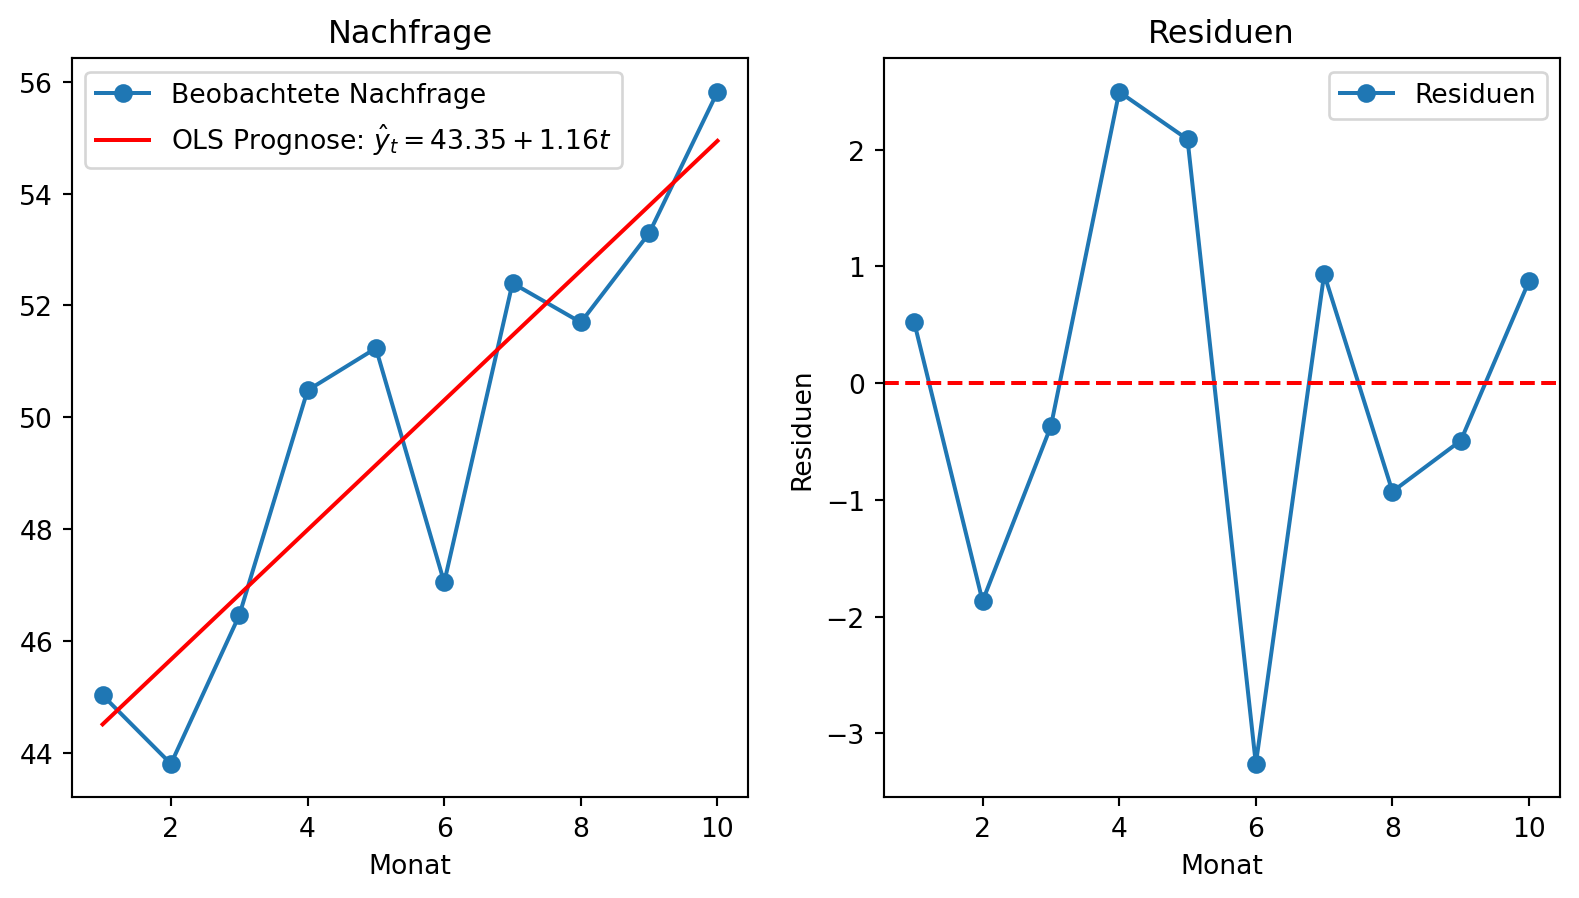

In [18]:
# Wie zuvor zeichnen wir die Prognose (die rote Gerade) und die Residuen

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
axes[0].plot(dt["time"], dt["y_predicted_OLS"], 'r-', label=r'OLS Prognose: $\hat{y}_t = 43.35 +  1.16 t$')
axes[0].set_title('Nachfrage')
axes[0].set_xlabel('Monat')
axes[0].legend()

# Plot the residuals
axes[1].plot(dt["time"], dt["residuals_OLS"], 'o-', label='Residuen')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_title('Residuen')
axes[1].set_xlabel('Monat')
axes[1].set_ylabel('Residuen')
axes[1].legend()

Lassen Sie uns am Schluss die Residuenquadratsumme für diese Gerade und für die drei naiven Prognosen berechnen. Die Residuenquadratsummen sind

$$
\begin{align*}
RSS(43.35, 1.16) & = 27.8 \quad \text{OLS} \\
RSS(45, 0.6) & = 74.04 \quad \text{Naiv 1} \\
RSS(42, 1.7) & = 78.31 \quad \text{Naiv 2}\\
RSS(50, 0.3) & = 125.85 \quad \text{Naiv 3} \\
\end{align*}
$$

Wie erwartet, liefern die durch OLS gefundenen Koeffizienten die kleinste Residuenquadratsumme.

In [19]:
(dt["residuals_OLS"]**2).sum(), (dt["residuals_naive"]**2).sum(), (residuals_1**2).sum(), (residuals_2**2).sum()

(np.float64(27.85742054236046),
 np.float64(74.04037194983103),
 np.float64(78.31092014872564),
 np.float64(125.85180115549095))

In [20]:
# Im übrigen, können wir die Residuenquadratsumme der OLS-Koeffizienten auch 
# aus dem Gurobi modell auslesen, denn das ist der Wert der Zielfunktion (RSS) im Optimum.

print("Gurobi RSS:", m.ObjVal)

Gurobi RSS: 27.85742054235924


## Kleinste absolute Abweichungen

Eine andere Möglichkeit ist es, die Koeffizienten so zu bestimmen, dass die Summe der absoluten Abweichungen minimiert wird. Das heißt, wir minimieren die Summe der Beträge der Abweichungen:

$$
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |y_t - (\beta_0 + \beta_1 t )|
$$

Dasselbe heisst auf English **Least Absolute Deviations** (LAD) Schätzungen.

Text(0, 0.5, 'Summe der absoluten Residuen')

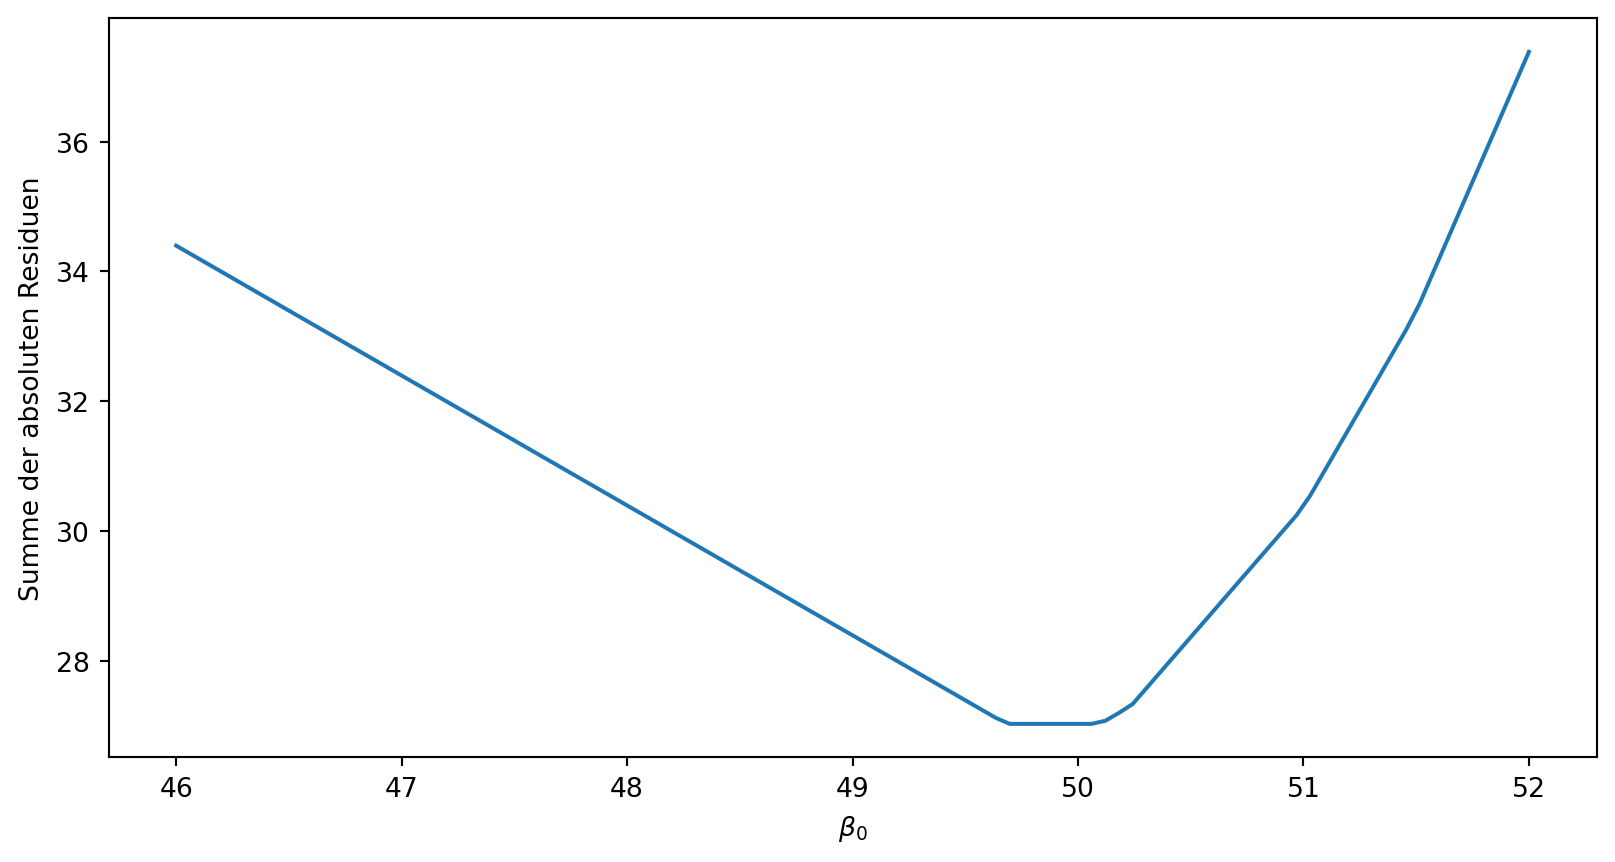

In [21]:
#| code-fold: true

# Compute the sum of absolute residuals for a range of values for beta_0

beta_0_values = np.linspace(46, 52, 100)

residuals = np.zeros((len(beta_0_values), periods))

for i in range(len(beta_0_values)):
    y_predicted = beta_0_values[i] + 0.2 * dt["time"]
    residuals[i, :] = dt["y"] - y_predicted

# Calculate the sum of absolute residuals
sum_abs_residuals = np.sum(np.abs(residuals), axis=1)

# Plot the sum of absolute residuals
plt.figure(figsize=(10, 5))
plt.plot(beta_0_values, sum_abs_residuals)
plt.xlabel(r'$\beta_0$')
plt.ylabel('Summe der absoluten Residuen')

Auf den ersten Blick sieht es so aus, dass diese Aufgabe eher nicht in unsere lineare Welt passt, denn wir haben hier die Betragsfunktion und diese ist nicht linear. Es stellt sich jedoch heraus, dass wir diese Aufgabe mit den Methoden der linearen Optimierung lösen können. Die Residuen $r_t$ sind wie zuvor definiert:

$$
r_t = y_t - (\beta_0 + \beta_1 t)
$$

und wir minimieren die Summe der Beträge der Residuen:

$$
\begin{align*}
\min_{\beta_0, \beta_1} \sum_{t = 1}^{T} |r_t|
\end{align*}
$$

Wir können die Betragsfunktion mit Hilfe von zwei Variablen $r^{+}_t$ und $r^{-}_t$ linearisieren. Wir können jede beliebige Zahl als Differenz von zwei nicht-negativen Zahlen darstellen:

$$
\begin{align*}
5 & = 5 - 0 \\
-3 & = 0 - 3 \\
r_t & = r^{+}_t - r^{-}_t \\
\end{align*}
$$

Der Betrag einer Zahl $x$ ist dann einfach die Summe der beiden nicht-negativen Zahlen:

$$
\begin{align*}
|5| & = 5 + 0 \\
|-3| & = 0 + 3 \\
|r_t| & = r^{+}_t + r^{-}_t \\
\end{align*}
$$

Jetzt können wir die Beträge der Residuen $r_t$ durch die Summe der negativen und positiven Residuen $r^{+}_t$ und $r^{-}_t$ ersetzen. Dann wird die Zielfunktion:

$$
\begin{align*}
\min \sum_{t = 1}^{T} |r_t| & = \min \sum_{t = 1}^{T} (r^{+}_t + r^{-}_t) \\
\end{align*}
$$

Die Einschränkungen sind dann:

$$
\begin{align*}
r_t = r^{+}_t - r^{-}_t & = y_t - (\beta_0 + \beta_1 t), \quad t = 1,\ldots,T\\
r^{+}_t & \geq 0 \\
r^{-}_t & \geq 0 \\
\end{align*}
$$

Wir haben das Modell vollständig spezifiziert. Falls Sie unsicher sind, was die ganze Notation bedeutet, schauen Sie sich die Langform des Modells an.

:::{.callout-note collapse="true"}
## Langform der Aufgabe

Die Zielfunktion ist:

$$
\begin{align*}
\min \sum_{t = 1}^{T = 10} (r^{+}_t + r^{-}_t) & = \min \sum_{t = 1}^{T=10} r^{+}_t + \sum_{t = 1}^{T=10} r^{-}_t \\
& = \min \left((r^{+}_1 + r^{+}_2 + r^{+}_3 + r^{+}_4  + r^{+}_5 + r^{+}_6 + r^{+}_7 + r^{+}_8 + r^{+}_9 + r^{+}_{10}) + (r^{-}_1
+ r^{-}_2 + r^{-}_3 + r^{-}_4  + r^{-}_5 + r^{-}_6 + r^{-}_7 + r^{-}_8 + r^{-}_9 + r^{-}_{10}) \right) \\
\end{align*}
$$

Die Einschränkungen sind 10 (weil $T=10$) Gleichungen:

$$
\begin{align*}
t = 1 \rightarrow r^{+}_1 - r^{-}_1 & = y_1 - (\beta_0 + \beta_1 \cdot 1) \\
t = 2 \rightarrow r^{+}_2 - r^{-}_2 & = y_2 - (\beta_0 + \beta_1 \cdot 2) \\
t = 3 \rightarrow r^{+}_3 - r^{-}_3 & = y_3 - (\beta_0 + \beta_1 \cdot 3) \\
t = 4 \rightarrow r^{+}_4 - r^{-}_4 & = y_4 - (\beta_0 + \beta_1 \cdot 4) \\
t = 5 \rightarrow r^{+}_5 - r^{-}_5 & = y_5 - (\beta_0 + \beta_1 \cdot 5) \\
t = 6 \rightarrow r^{+}_6 - r^{-}_6 & = y_6 - (\beta_0 + \beta_1 \cdot 6) \\
t = 7 \rightarrow r^{+}_7 - r^{-}_7 & = y_7 - (\beta_0 + \beta_1 \cdot 7) \\
t = 8 \rightarrow r^{+}_8 - r^{-}_8 & = y_8 - (\beta_0 + \beta_1 \cdot 8) \\
t = 9 \rightarrow r^{+}_9 - r^{-}_9 & = y_9 - (\beta_0 + \beta_1 \cdot 9) \\
t = 10 \rightarrow r^{+}_{10} - r^{-}_{10} & = y_{10} - (\beta_0 + \beta_1 \cdot 10) \\
\end{align*}
$$

:::

Zuerst werden wir das Modell (fast) ohne Matrixoperationen umsetzen.

Wir brauchen 10 Variablen für die positiven Teile der Residuen: $r^{+}_t$, 10 Variablen für die negativen Teile der Residuen: $r^{-}_t$, und 2 Variablen für die Koeffizienten $\beta_0$ und $\beta_1$. Die Variablen für die Residuen sind nichtnegativ, allerdings sind die Variablen für $\beta_0$ und $\beta_1$ unbeschränkt. Deswegen setzen wir die untere Schranken auf $-\infty$ (`lb=-GRB.INFINITY`).


In [22]:

mlad1 = gp.Model("LAD Regression (ohne Matrizen)")

# Hier definieren wir die Variablen für die Koeffizienten beta_0 und beta_1.

beta_0 = mlad1.addMVar(1, lb=-GRB.INFINITY, name="beta_0")
beta_1 = mlad1.addMVar(1, lb=-GRB.INFINITY, name="beta_1")

# Nun müssen wir die Prognosen berechnen

predicted = beta_0 + beta_1 * dt["time"].values

# Danach definieren wir die Residuen. Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (dt.shape[0]).

r_plus = mlad1.addMVar(10, name="r")
r_minus = mlad1.addMVar(10, name="r")

# Einschränkungen für die Residuen

mlad1.addConstr(r_plus - r_minus  == dt["y"].values - predicted, name="Residuals_plus")


# Die Zielfunktion ist die Summe von zwei Summen: die Summe der positiven Residuen und die Summe der negativen Residuen.

mlad1.setObjective(r_plus.sum() + r_minus.sum(), GRB.MINIMIZE)

mlad1.write("model-lad-no-matrices.lp")

with open("model-lad-no-matrices.lp", "r") as f:
    print(f.read())


\ Model LAD Regression (ohne Matrizen)
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  r[0] + r[1] + r[2] + r[3] + r[4] + r[5] + r[6] + r[7] + r[8] + r[9] + r[0]
   + r[1] + r[2] + r[3] + r[4] + r[5] + r[6] + r[7] + r[8] + r[9]
Subject To
 Residuals_plus[0]: beta_0[0] + beta_1[0] + r[0] - r[0]
   = 45.02810469193533
 Residuals_plus[1]: beta_0[0] + 2 beta_1[0] + r[1] - r[1]
   = 43.80031441673444
 Residuals_plus[2]: beta_0[0] + 3 beta_1[0] + r[2] - r[2]
   = 46.45747596821148
 Residuals_plus[3]: beta_0[0] + 4 beta_1[0] + r[3] - r[3]
   = 50.48178639840292
 Residuals_plus[4]: beta_0[0] + 5 beta_1[0] + r[4] - r[4]
   = 51.23511598029994
 Residuals_plus[5]: beta_0[0] + 6 beta_1[0] + r[5] - r[5]
   = 47.04544424024718
 Residuals_plus[6]: beta_0[0] + 7 beta_1[0] + r[6] - r[6]
   = 52.40017683505118
 Residuals_plus[7]: beta_0[0] + 8 beta_1[0] + r[7] - r[7]
   = 51.69728558340461
 Residuals_plus[8]: beta_0[0] + 9 beta_1[0] + r[8] - r[8]
   = 53.2935622

## Umsetzung mit Matrixmultiplikation

Diese Implementation ist allerdings unbequem. Falls wir die folgende Prognosegleichung hätten:

$$
\hat{y}_t = \beta_0 + \beta_1 t + \beta_2 t^2
$$

dann müßten wir den Code oben anpassen, denn die Schätzung $\hat{y}_t$ die dort gemacht wird nicht mehr korrekt sein wird.

Es hilft, die Schätzungen in Matrixform darzustellen.

Bei gegebenen Koeffizienten $\beta_0$ und $\beta_1$ können wir die Nachfrage für alle Monate $t$ aufschreiben als:

$$
\begin{align*}
t = 1 \rightarrow & \quad \hat{y}_1 = \beta_0 + \beta_1 \cdot 1 \\
t = 2 \rightarrow & \quad \hat{y}_2 = \beta_0 + \beta_1 \cdot 2 \\
\vdots \\
t = T \rightarrow & \quad \hat{y}_T = \beta_0 + \beta_1 \cdot T \\
\end{align*}
$$

Das können wir in Matrixform schreiben:

$$
\begin{align*}
\hat{y} = \begin{pmatrix} \hat{y}_1 \\ \hat{y}_2 \\ \vdots \\ \hat{y}_T \end{pmatrix} & = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix} \beta_0 + \begin{pmatrix} 1 \\ 2 \\ \vdots \\ T \end{pmatrix} \beta_1 \\
\end{align*}
$$

$$
\begin{align*}
\hat{y} & = \begin{pmatrix} 1 & 1  \\ 1 & 2 \\ \vdots & \vdots \\ 1 & T \end{pmatrix} \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix} \\ 
\end{align*}
$$

oder in noch kompakterer Form:

$$
\begin{align*}
\hat{y} & = X \beta \\
\end{align*}
$$

Die Matrix $X$ nennen wir die Designmatrix.


In [23]:
# Um die X-Matrix zu erstellen, verwenden wir die Funktiob dmatrix aus patsy
from patsy import dmatrix

X = dmatrix("1 + time", data = dt)
X

DesignMatrix with shape (10, 2)
  Intercept  time
          1     1
          1     2
          1     3
          1     4
          1     5
          1     6
          1     7
          1     8
          1     9
          1    10
  Terms:
    'Intercept' (column 0)
    'time' (column 1)

In [24]:
# Beispiel: für beta_0 = 40 und beta_1 = 0.2 sind die Prognosen

X @ np.array([40, 0.2])

array([40.2, 40.4, 40.6, 40.8, 41. , 41.2, 41.4, 41.6, 41.8, 42. ])

In [25]:
m = gp.Model("LAD Regression")

# Wir definieren die Variablen (r+)

# Die Anzahl der Residuen ist gleich der Anzahl der Beobachtungen (Zeilen in X, also X.shape[0])
r_plus = m.addMVar(X.shape[0], name="r_plus")
r_minus = m.addMVar(X.shape[0], name="r_minus")

# Wir definieren die Variablen (beta_0, beta_1)
# Die Anzahl der Parameter ist gleich der Anzahl der Spalten in X (also X.shape[1])
betas = m.addMVar(X.shape[1], lb=-GRB.INFINITY, name="betas")

# Die Einschränkungen

m.addConstr(dt["y"].values - X @ betas == r_plus - r_minus, name="Residuals")

# Die Zielfunktion (Objective Function)

m.setObjective(r_plus.sum() + r_minus.sum(), GRB.MINIMIZE)

m.write("model-lad.lp")
with open("model-lad.lp", "r") as f:
    print(f.read())
    
m.optimize()


\ Model LAD Regression
\ LP format - for model browsing. Use MPS format to capture full model detail.
Minimize
  r_plus[0] + r_plus[1] + r_plus[2] + r_plus[3] + r_plus[4] + r_plus[5]
   + r_plus[6] + r_plus[7] + r_plus[8] + r_plus[9] + r_minus[0]
   + r_minus[1] + r_minus[2] + r_minus[3] + r_minus[4] + r_minus[5]
   + r_minus[6] + r_minus[7] + r_minus[8] + r_minus[9]
Subject To
 Residuals[0]: - r_plus[0] + r_minus[0] - betas[0] - betas[1]
   = -45.02810469193533
 Residuals[1]: - r_plus[1] + r_minus[1] - betas[0] - 2 betas[1]
   = -43.80031441673444
 Residuals[2]: - r_plus[2] + r_minus[2] - betas[0] - 3 betas[1]
   = -46.45747596821148
 Residuals[3]: - r_plus[3] + r_minus[3] - betas[0] - 4 betas[1]
   = -50.48178639840292
 Residuals[4]: - r_plus[4] + r_minus[4] - betas[0] - 5 betas[1]
   = -51.23511598029994
 Residuals[5]: - r_plus[5] + r_minus[5] - betas[0] - 6 betas[1]
   = -47.04544424024718
 Residuals[6]: - r_plus[6] + r_minus[6] - betas[0] - 7 betas[1]
   = -52.40017683505118
 Resi

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]


Thread count: 32 physical cores, 32 logical processors, using up to 32 threads


Optimize a model with 10 rows, 22 columns and 40 nonzeros (Min)


Model fingerprint: 0x208785ed


Model has 20 linear objective coefficients


Coefficient statistics:


  Matrix range     [1e+00, 1e+01]


  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


  RHS range        [4e+01, 6e+01]


Presolve time: 0.00s


Presolved: 10 rows, 22 columns, 40 nonzeros


Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0      handle free variables                          0s


      10    1.3705481e+01   0.000000e+00   0.000000e+00      0s


Solved in 10 iterations and 0.00 seconds (0.00 work units)


Optimal objective  1.370548061e+01


In [26]:
dt["y_predicted_LAD"] = X @ betas.X
dt["residuals_LAD"] = dt["y"] - dt["y_predicted_LAD"]

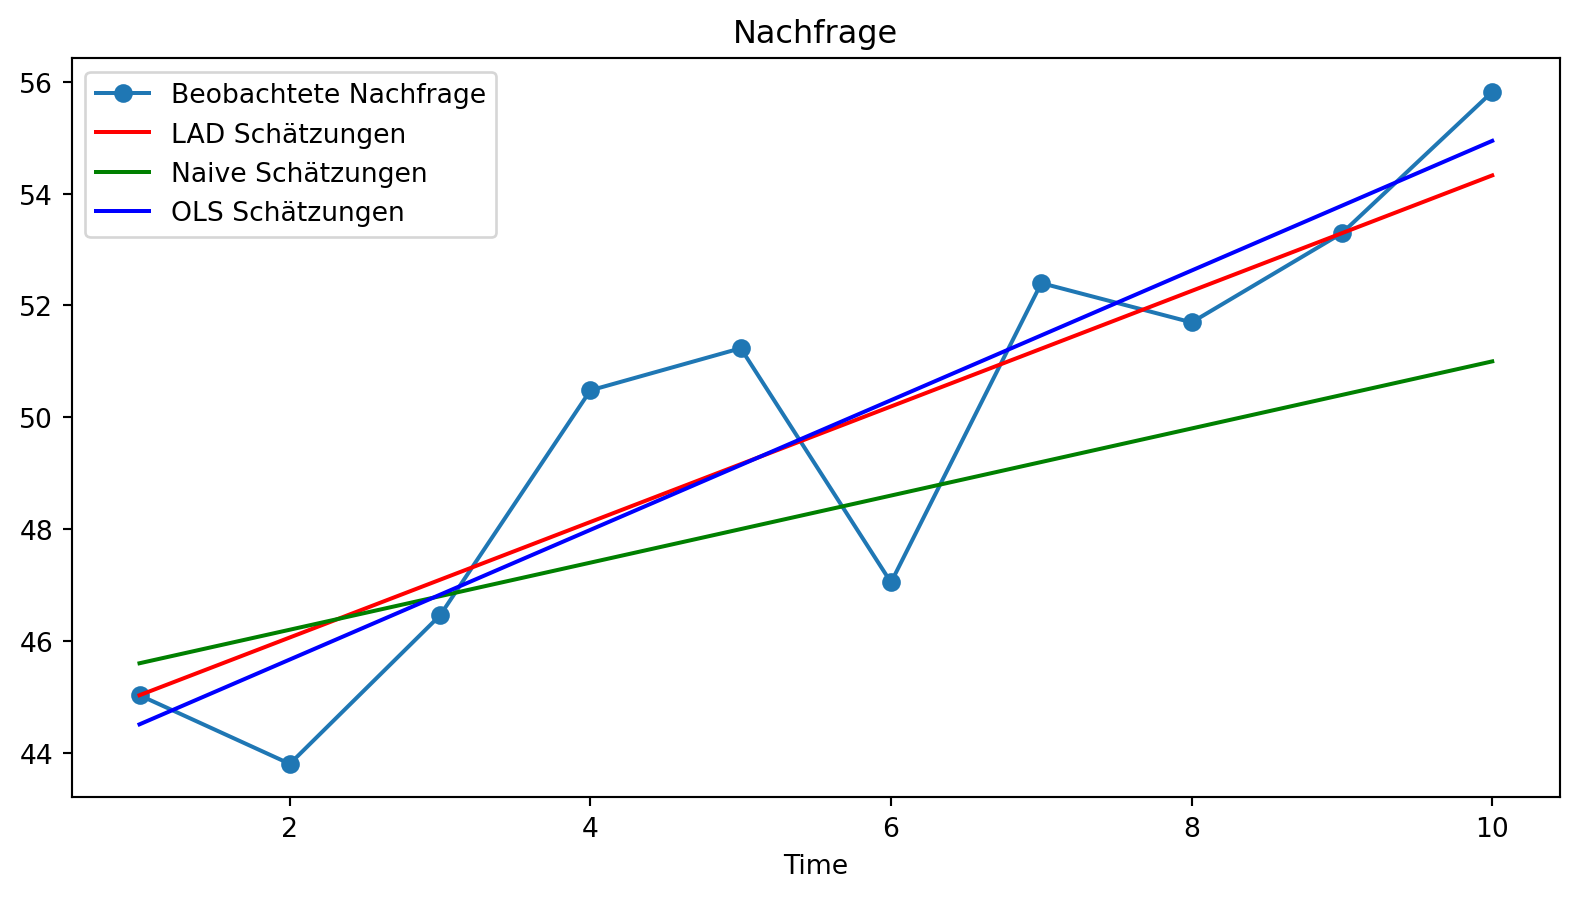

In [27]:
# Plot the data and the trend line

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(dt["time"], dt["y"], 'o-', label='Beobachtete Nachfrage')
ax.plot(dt["time"], dt["y_predicted_LAD"], 'r-', label='LAD Schätzungen')
ax.plot(dt["time"], dt["y_predicted_naive"], 'g-', label='Naive Schätzungen')
ax.plot(dt["time"], dt["y_predicted_OLS"], 'b-', label='OLS Schätzungen')

ax.set_title('Nachfrage')
ax.set_xlabel('Time')
ax.legend()
